In [2]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2025-10-14 18:03:36.259271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Step 2: Load the dataset
file_path = 'datasets/cleaned/fx_predictions_dataset.csv'
data = pd.read_csv(file_path)

In [4]:
data.head()

,Date,Buying,Selling,Mid Rate,GDP,Interbank weighted average rate,Monetary policy rate,Oil_Price,Cocoa_Price,Gold_Price,Headline Inflation
0,30/11/2023,11.61,11.6264,11.6206,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
1,29/11/2023,11.61,11.6169,11.6111,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2,28/11/2023,11.59,11.6049,11.5991,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
3,27/11/2023,11.58,11.5958,11.59,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
4,24/11/2023,11.58,11.5888,11.583,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             3950 non-null   object 
 1   Buying                           3950 non-null   float64
 2   Selling                          3950 non-null   object 
 3   Mid Rate                         3950 non-null   object 
 4   GDP                              3950 non-null   float64
 5   Interbank weighted average rate  3950 non-null   float64
 6   Monetary policy rate             3950 non-null   float64
 7   Oil_Price                        3950 non-null   float64
 8   Cocoa_Price                      3950 non-null   float64
 9   Gold_Price                       3950 non-null   float64
 10  Headline Inflation               3950 non-null   float64
dtypes: float64(8), object(3)
memory usage: 339.6+ KB


In [6]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             3950 non-null   datetime64[ns]
 1   Buying                           3950 non-null   float64       
 2   Selling                          3950 non-null   object        
 3   Mid Rate                         3950 non-null   object        
 4   GDP                              3950 non-null   float64       
 5   Interbank weighted average rate  3950 non-null   float64       
 6   Monetary policy rate             3950 non-null   float64       
 7   Oil_Price                        3950 non-null   float64       
 8   Cocoa_Price                      3950 non-null   float64       
 9   Gold_Price                       3950 non-null   float64       
 10  Headline Inflation               3950 non-null   float64    

/var/folders/pq/lv4328kx4fjg40sltdfjtrcm0000gn/T/ipykernel_9350/493717167.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


In [7]:
data.drop(columns=['Selling', 'Mid Rate'], inplace=True)

In [8]:
data.set_index('Date', inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2023-11-30 to 2008-01-02
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Buying                           3950 non-null   float64
 1   GDP                              3950 non-null   float64
 2   Interbank weighted average rate  3950 non-null   float64
 3   Monetary policy rate             3950 non-null   float64
 4   Oil_Price                        3950 non-null   float64
 5   Cocoa_Price                      3950 non-null   float64
 6   Gold_Price                       3950 non-null   float64
 7   Headline Inflation               3950 non-null   float64
dtypes: float64(8)
memory usage: 277.7 KB


In [10]:
TargetColumn = 'Buying'

In [11]:
# Drop rows with missing values
data.isnull().sum()

Buying                             0
GDP                                0
Interbank weighted average rate    0
Monetary policy rate               0
Oil_Price                          0
Cocoa_Price                        0
Gold_Price                         0
Headline Inflation                 0
dtype: int64

In [12]:
# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame for easier manipulation
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

# Step 4: Prepare the data for LSTM
# Define the target variable and features
target = scaled_data['Buying']
features = scaled_data.drop(columns=['Buying'])

In [13]:
# Convert to numpy arrays
x = features.values
y = target.values

# Reshape X into 3D array for LSTM [samples, timesteps, features]
timesteps = 10  # Number of previous steps to consider
x_lstm = []
y_lstm = []

for i in range(timesteps, len(x)):
    x_lstm.append(x[i-timesteps:i])
    y_lstm.append(y[i])

x_lstm, y_lstm = np.array(x_lstm), np.array(y_lstm)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_lstm, y_lstm, test_size=0.2, shuffle=False)

In [14]:
# Step 5: Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(
        x_train.shape[1], x_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Step 6: Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0122 - val_loss: 0.0015
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_

In [16]:
# Step 7: Evaluate the model
# Predict on the test set
y_pred = model.predict(x_test)

# Inverse transform the predictions and actual values
y_test_scaled = scaler.inverse_transform(np.concatenate(
    (np.zeros((len(y_test), x.shape[1])), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_scaled = scaler.inverse_transform(np.concatenate(
    (np.zeros((len(y_pred), x.shape[1])), y_pred), axis=1))[:, -1]

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


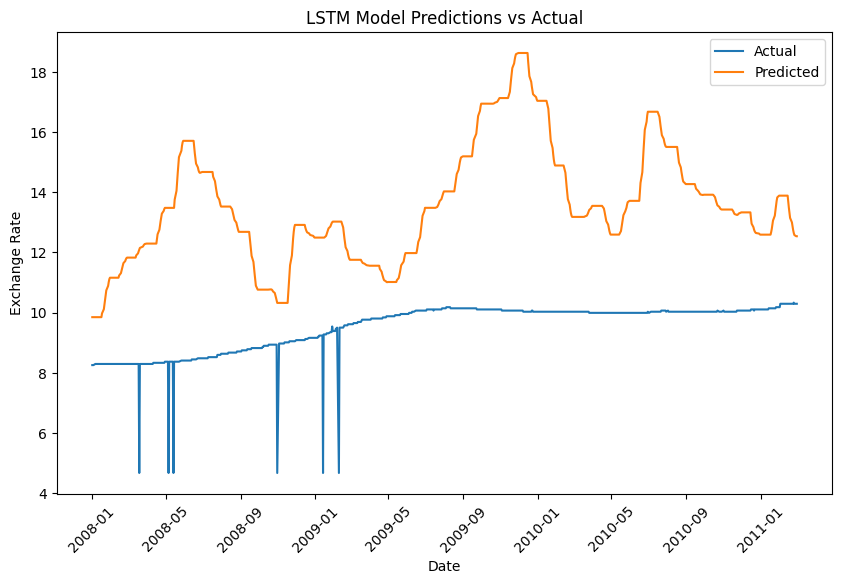

In [17]:
# Extract the dates for the test set
test_dates = data.index[-len(y_test):]

# Plot the results with dates
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_scaled, label='Actual')
plt.plot(test_dates, y_pred_scaled, label='Predicted')
plt.legend()
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

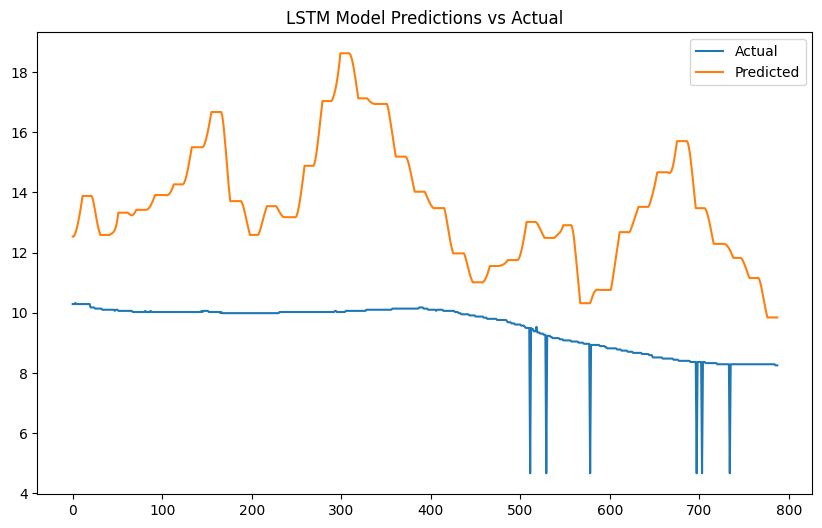

In [18]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_scaled, label='Predicted')
plt.legend()
plt.title('LSTM Model Predictions vs Actual')
plt.show()

### VAR

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [20]:
var_data = pd.read_csv('datasets/cleaned/fx_predictions_dataset.csv', parse_dates=['Date'], index_col='Date')
var_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2023-11-30 to 2008-01-02
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Buying                           3950 non-null   float64
 1   Selling                          3950 non-null   object 
 2   Mid Rate                         3950 non-null   object 
 3   GDP                              3950 non-null   float64
 4   Interbank weighted average rate  3950 non-null   float64
 5   Monetary policy rate             3950 non-null   float64
 6   Oil_Price                        3950 non-null   float64
 7   Cocoa_Price                      3950 non-null   float64
 8   Gold_Price                       3950 non-null   float64
 9   Headline Inflation               3950 non-null   float64
dtypes: float64(8), object(2)
memory usage: 339.5+ KB


/var/folders/pq/lv4328kx4fjg40sltdfjtrcm0000gn/T/ipykernel_9350/25287385.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  var_data = pd.read_csv('datasets/cleaned/fx_predictions_dataset.csv', parse_dates=['Date'], index_col='Date')


In [23]:
var_data.drop(columns=['Selling', 'Mid Rate'], inplace=True)

In [24]:
var_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2023-11-30 to 2008-01-02
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Buying                           3950 non-null   float64
 1   GDP                              3950 non-null   float64
 2   Interbank weighted average rate  3950 non-null   float64
 3   Monetary policy rate             3950 non-null   float64
 4   Oil_Price                        3950 non-null   float64
 5   Cocoa_Price                      3950 non-null   float64
 6   Gold_Price                       3950 non-null   float64
 7   Headline Inflation               3950 non-null   float64
dtypes: float64(8)
memory usage: 277.7 KB


In [27]:
var_data.head()

,Buying,GDP,Interbank weighted average rate,Monetary policy rate,Oil_Price,Cocoa_Price,Gold_Price,Headline Inflation
Date,,,,,,,,
2023-11-30,11.61,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2023-11-29,11.61,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2023-11-28,11.59,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2023-11-27,11.58,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41
2023-11-24,11.58,51281.1,29.1,30.0,81.85,2469.1,1726.39,26.41


In [35]:
# Function to plot time series
def plot_series(data):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    for i, col in enumerate(data.columns):
        data[col].plot(ax=axes[i % len(axes)], title=col)
        axes[i % len(axes)].set_ylabel('Values')
        axes[i % len(axes)].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

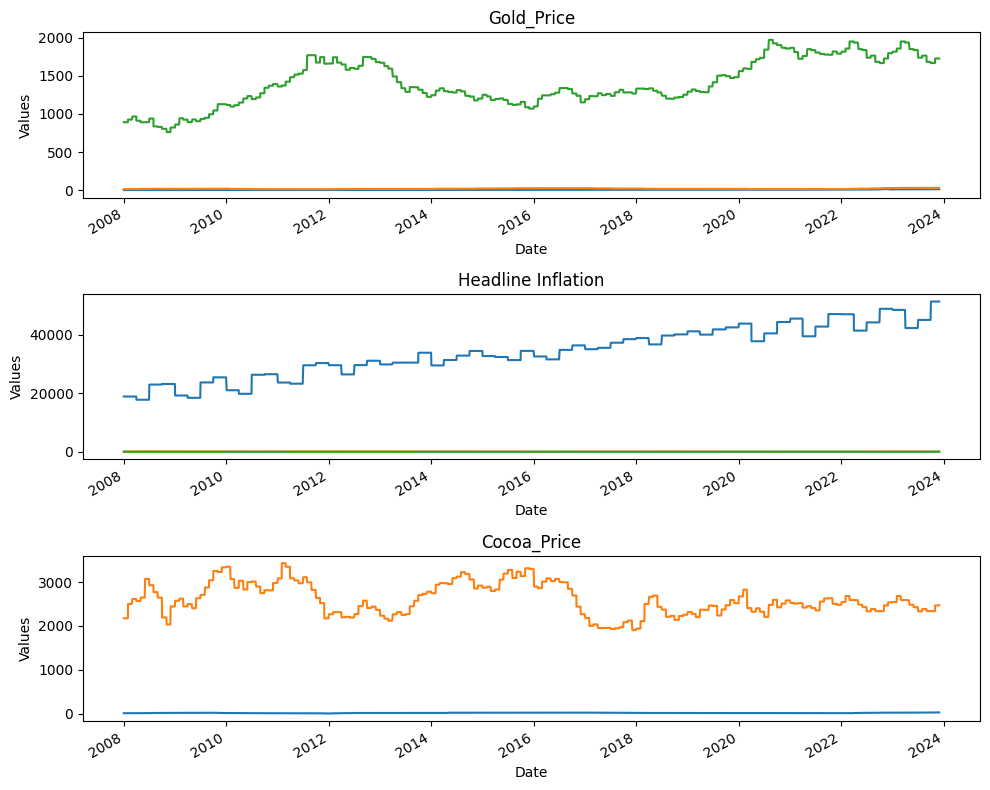

In [36]:
plot_series(var_data)

In [37]:
# Check stationarity of time series using ADF test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [39]:
# Section for VAR analysis
def var_analysis(data):
    # Step 1: Check stationarity and visualize the original data
    print("Step 1: Checking stationarity")
    for col in data.columns:
        print('Stationarity test for', col)
        check_stationarity(data[col])

    # Step 2: Applying VAR model
    print("\nStep 2: Applying VAR model")
    model = VAR(data)
    results = model.fit()

    # Step 3: Forecasting
    print("\nStep 3: Forecasting")
    lag_order = results.k_ar
    forecast = results.forecast(data.values[-lag_order:], steps=10)

    # Step 4: Visualizing forecast
    print("\nStep 4: Visualizing forecast")
    forecast_index = pd.date_range(start='2024-04-11', periods=10)
    forecast_data = pd.DataFrame(
        forecast, index=forecast_index, columns=data.columns)
    plot_series(pd.concat([data, forecast_data]))

Step 1: Checking stationarity
Stationarity test for Buying
ADF Statistic: -2.6386402678496568
p-value: 0.08527114507745209
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for GDP
ADF Statistic: -1.6090297860437934
p-value: 0.4790561281885536
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Interbank weighted average rate
ADF Statistic: -2.2725779717688015
p-value: 0.1809646777748536
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Monetary policy rate
ADF Statistic: -2.280975671595982
p-value: 0.1781771216437154
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Oil_Price
ADF Statistic: -2.74808904199706
p-value: 0.06607997501667974
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Cocoa_Price
ADF Statistic: -2.6388859988118702
p-value: 0.08522365604300663
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Gold_Price
ADF Statistic: -0

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


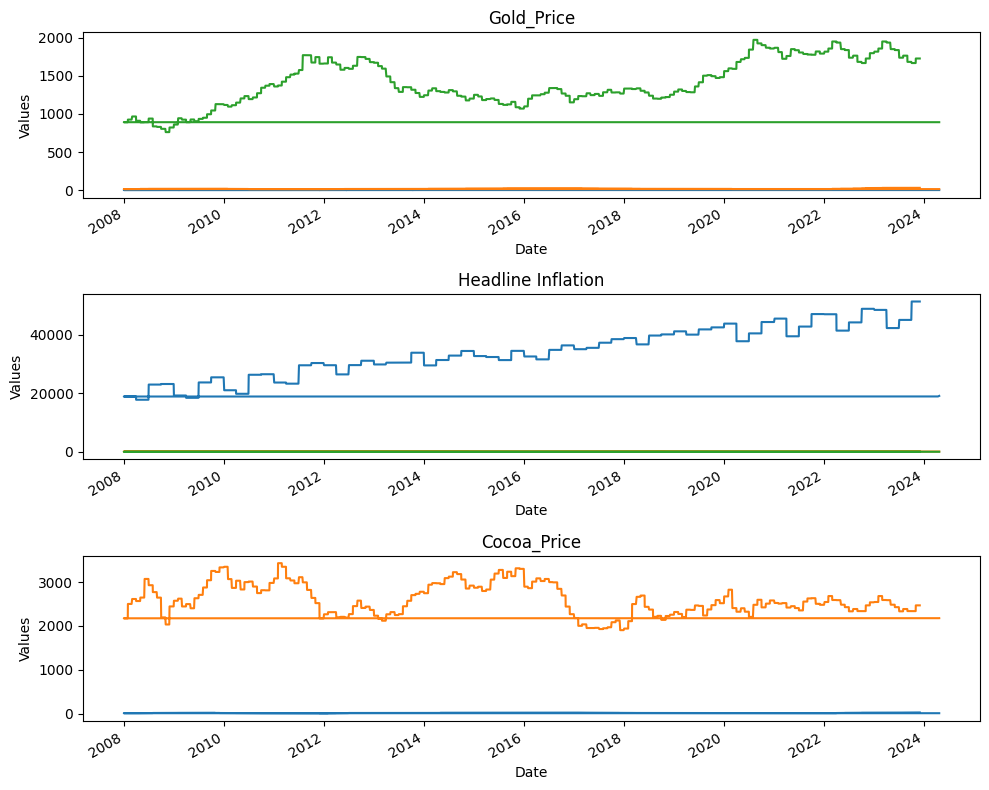

In [40]:
# Perform VAR analysis
var_analysis(var_data)

Step 1: Checking stationarity
Stationarity test for Buying
ADF Statistic: -13.516573786211415
p-value: 2.786877663972598e-25
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for GDP
ADF Statistic: -62.84604208900987
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Interbank weighted average rate
ADF Statistic: -8.324819074855515
p-value: 3.4935452249143606e-13
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Monetary policy rate
ADF Statistic: -62.866461320400276
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Oil_Price
ADF Statistic: -8.76561262718734
p-value: 2.60262689057681e-14
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Cocoa_Price
ADF Statistic: -62.817555956589416
p-value: 0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationarity test for Gold_Price
ADF Statistic: -11.202128539913392
p-value: 2.23038730275

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


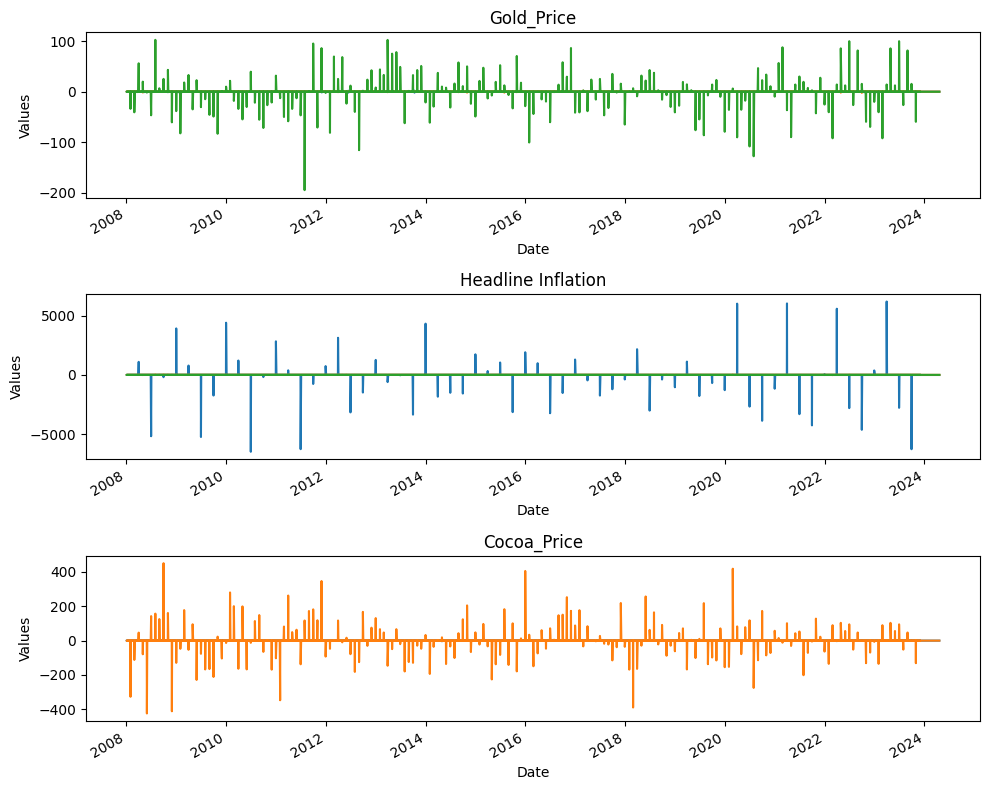

In [41]:
# Difference the data to stationarise (first difference)
stationary_data = var_data.diff().dropna()

# Run VAR analysis on the stationarised data
var_analysis(stationary_data)
